<a href="https://colab.research.google.com/github/anubhavgupta1/Udacity/blob/main/Frameworks/Pytorch/Blob%20Data/BlobData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 
import seaborn as sns
import time
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

import torch

In [2]:
torch.manual_seed(0)

In [3]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

## Generate Dataset

In [4]:
data, labels = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


## Plot the Data

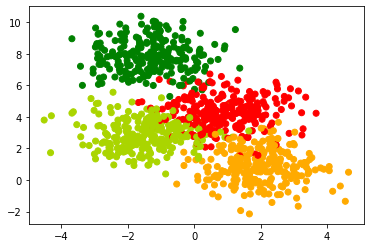

In [5]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

## Train Test Split

In [6]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0)
print(X_train.shape, X_val.shape, labels.shape)

(750, 2) (250, 2) (1000,)


## Using torch tensors and autograd

In [7]:
X_train, Y_train, X_val, Y_val = map(torch.tensor, (X_train, Y_train, X_val, Y_val))

In [8]:
print(X_train.shape, Y_train.shape)

torch.Size([750, 2]) torch.Size([750])


## Model Class

In [9]:
class BlobData:
  def __init__(self):
    torch.manual_seed(0)
    
    self.weights1 = torch.randn(2, 2) / math.sqrt(2)
    self.weights1.requires_grad_()
    
    self.bias1 = torch.zeros(2, requires_grad=True)
    
    self.weights2 = torch.randn(2, 4) / math.sqrt(2)
    self.weights2.requires_grad_()
    
    self.bias2 = torch.zeros(4, requires_grad=True)

  def predict(self, X):
    a1 = torch.matmul(X, self.weights1) + self.bias1 # (N, 2) x (2, 2) -> (N, 2)
    h1 = a1.sigmoid() # (N, 2)
    a2 = torch.matmul(h1, self.weights2) + self.bias2 # (N, 2) x (2, 4) -> (N, 4)
    h2 = a2.exp()/a2.exp().sum(-1).unsqueeze(-1) # (N, 4)
    return h2
  
  def loss_fn(self, y_hat, y):
    return -(y_hat[range(y.shape[0]), y].log()).mean()
  
  def accuracy(self, y_hat, y):
    pred_labels = torch.argmax(y_hat, dim=1)
    pred_binary = (pred_labels == y).float()
    average_acc = pred_binary.mean()
    return  average_acc

  def fit(self,X,Y,epochs = 1000, learning_rate = 1):
    loss_arr = []
    acc_arr  = []
    for epoch in range(epochs):
      Y_hat = self.predict(X)
      
      loss = self.loss_fn(Y_hat, Y)
      loss.backward()
      loss_arr.append(loss.item())
      
      acc = self.accuracy(Y_hat, Y)
      acc_arr.append(acc.item())
      
      with torch.no_grad():
        self.weights1 -= self.weights1.grad * learning_rate
        self.bias1    -= self.bias1.grad    * learning_rate
        self.weights2 -= self.weights2.grad * learning_rate
        self.bias2    -= self.bias2.grad    * learning_rate
        
        self.weights1.grad.zero_()
        self.bias1.grad.zero_()
        self.weights2.grad.zero_()
        self.bias2.grad.zero_()
    
    plt.plot(loss_arr, 'r-')
    plt.plot(acc_arr, 'b-')
    plt.show()
    
    print('Loss before training', loss_arr[0])
    print('Loss after training', loss_arr[-1])
    return loss_arr, acc_arr


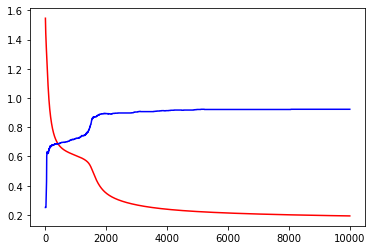

Loss before training 1.5456440448760986
Loss after training 0.19288595020771027


In [10]:
model = BlobData()
loss, acc = model.fit(X_train.float(),Y_train.long(),learning_rate = 0.2,epochs = 10000)

In [11]:
Y_pred = model.predict(X_val.float())
test_acc = model.accuracy(Y_pred,Y_val.long())

In [12]:
print("Training accuracy is : ", acc[-1])
print("Test accuracy is : ", test_acc.item())

Training accuracy is :  0.9226666688919067
Test accuracy is :  0.9440000057220459


In [13]:
Y_pred_train = model.predict(X_train.float())
Y_pred_train = Y_pred_train.float()
Y_pred_train = Y_pred_train.detach().numpy()
Y_pred_train = np.argmax(Y_pred_train, axis=1)

In [14]:
X1,X2,Y = (X_train[:,0]).float(), (X_train[:,1]).float(),Y_train.numpy() 
X1, X2 = X1.numpy(), X2.numpy()

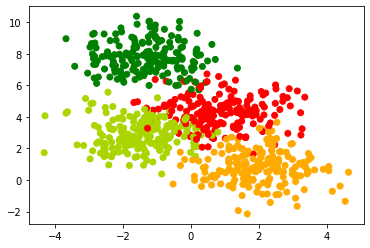

In [15]:
plt.scatter(X1, X2, c=Y, cmap=my_cmap)
plt.show()

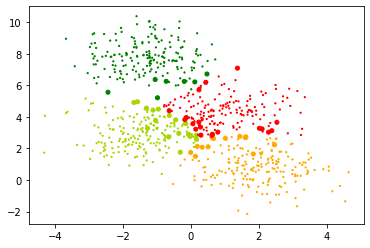

In [16]:
plt.scatter(X1, X2, c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y))+.1))
plt.show()